In [3]:
import jax
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
from typing import Sequence, Union
import lib
from sklearn.cluster import KMeans
import sklearn

In [31]:
time_delay_dim = 6
time_delay = 10
time_range = (0, 600, 0.02)
n_centers = 500

In [32]:
# n_points = len(np.arange(*time_range))
# constant_current_duration = 2500
# n_current_plateaus = n_points//constant_current_duration
# np.random.seed(21)
# random_i = np.random.uniform(-15, 60, size=(n_current_plateaus, 1))
# stimulus_list = (np.ones((n_current_plateaus, constant_current_duration))*random_i).reshape((-1, ))
# stimulus = lib.custom_stimulus(stimulus_list=stimulus_list, time_range=time_range, time_constant=10)

# stimulus = lib.lorenz1996_stimulus(N=8, F=6, time_range=time_range, initial_state=[1, 2, 8.01, 4, 8, 5], time_constant=10, rescale_factor=2.)
# stimulus.get_stimulus_list()

stimulus = lib.lorenz1963_stimulus(time_range=time_range, )
stimulus.get_stimulus_list()

# stimulus = lib.constant_stimulus(dc_stimulus=15, time_range=time_range)
# stimulus.get_stimulus_list()

training_neuron = lib.single_neuron_odeint(stimulus, [0, 0, 0, 0])
training_neuron.generate_sol()

In [6]:
drop_first_n_points = 5000
training_neuron.sol = training_neuron.sol[drop_first_n_points:]
stimulus.stimulus_list = stimulus.stimulus_list[drop_first_n_points:]

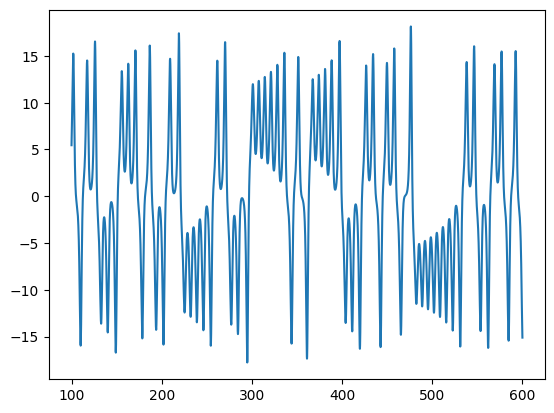

In [7]:
plt.plot(np.arange(*time_range)[drop_first_n_points:], stimulus.stimulus_list)

In [8]:
# get points in time delay coordinate and k-means centers
points_time_delay = np.array([np.roll(training_neuron.sol[:, 0], -i*time_delay) for i in range(time_delay_dim)]).T
points_time_delay = points_time_delay[: -time_delay*(time_delay_dim-1)]
kmeans = KMeans(n_clusters=n_centers, random_state=0, n_init="auto").fit(points_time_delay)

In [9]:
# search for sigma
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=8, algorithm="ball_tree").fit(kmeans.cluster_centers_)
distances, _ = nbrs.kneighbors(kmeans.cluster_centers_)
sigma = distances[:, -1]

In [10]:
# training by doing linear/ridge regression
class train_by_regression():
    def __init__(self, centers, voltage_list, current_list, time_delay, time_delay_dim, time_spacing, beta, R, membrane_capacitance=1) -> None:
        self.centers = centers # (n_centers, time_delay_dim)
        self.voltage_list = voltage_list
        self.current_list = current_list
        self.time_delay = time_delay
        self.time_delay_dim = time_delay_dim
        self.time_spacing = time_spacing
        self.beta = beta
        self.R = R # R = 1/sigma^2
        self.membrane_capacitance = membrane_capacitance
        self.X = None
        self.Y = None

        self._pre_processing()

    def _pre_processing(self):
        first_usable_t_idx = self.time_delay*(self.time_delay_dim-1) # the first point that can be used for training is the time_delay*(time_delay_dim-1)^th point.
        tmp_v = jnp.array([jnp.roll(self.voltage_list, -i*self.time_delay) for i in range(self.time_delay_dim)]).T
        tmp_v = tmp_v[:-1-first_usable_t_idx, :]

        def get_distances_to_centers(x):
            diff = self.centers - x
            dist = jnp.exp(-np.sum(diff**2, axis=-1)*self.R/2)
            return dist

        self.X = jax.vmap(get_distances_to_centers, in_axes=0)(tmp_v)
           
        tmp_delta_v = self.voltage_list[first_usable_t_idx+1:] - self.voltage_list[first_usable_t_idx:-1]
        tmp_i = (self.current_list + jnp.roll(self.current_list, -1))/2
        tmp_i = tmp_i[first_usable_t_idx:-1]
        self.Y = tmp_delta_v/self.time_spacing - tmp_i/self.membrane_capacitance

    def get_weights(self):
        ridge = sklearn.linear_model.Ridge(alpha=self.beta, fit_intercept=False)
        self.ridge = ridge.fit(self.X, self.Y)
        self.score = ridge.score(self.X, self.Y)
        return ridge.coef_
    
class rbf_model_fake_ann(nn.Module):
    time_delay_dim: int
    R: Union[Sequence[float], float]
    centers: Sequence[float]
    weights: Sequence[float]

    def __call__(self, x):
        x = jnp.atleast_2d(x)
        return jax.vmap(self.single_evaluation, in_axes=0)(x)

    def single_evaluation(self, x):
        x = x[:self.time_delay_dim]
        diff = (self.centers - x)**2
        # diff = jnp.sum(diff, axis=-1)/2*(self.sigma_inverse)**2
        diff = jnp.sum(diff, axis=-1)*self.R/2
        dist = jnp.exp(-diff)
        y = dist@self.weights
        return jnp.array([y])
    

In [11]:
R = 1/sigma**2
beta = 0.01
train_test = train_by_regression(kmeans.cluster_centers_, training_neuron.sol[:, 0], stimulus.stimulus_list, time_delay, time_delay_dim, time_spacing=time_range[-1], beta=beta, R=R)
w = train_test.get_weights()
rbf1 = rbf_model_fake_ann(time_delay_dim=time_delay_dim, R=R, centers=jnp.array(kmeans.cluster_centers_), weights=w)
pred_model = lib.prediction_model_with_current(rbf1, time_spacing=time_range[-1])
params = pred_model.init(jax.random.PRNGKey(0), jnp.zeros((time_delay_dim)), jnp.zeros((time_delay_dim))) # this is useless, but have to be here to take the place of some functions' arguments

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [12]:
train_test.score

0.9961915158580177

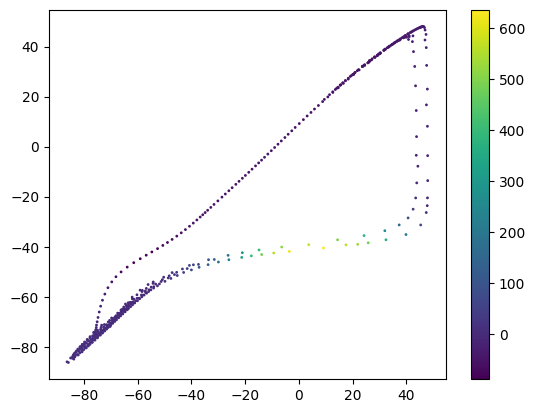

In [13]:
plot_start = 0 
plot_end = -1
def get_distances_to_centers(x):
    diff = kmeans.cluster_centers_ - x
    dist = jnp.exp(-np.sum(diff**2, axis=-1)*R/2)
    return dist
dist = jax.vmap(get_distances_to_centers, in_axes=0)(kmeans.cluster_centers_)

# plt.plot(points_time_delay[:, 1], points_time_delay[:, 0], linewidth=1)
plt.scatter(kmeans.cluster_centers_[:, -1][plot_start:plot_end], kmeans.cluster_centers_[:, -2][plot_start:plot_end], c=(dist@w)[plot_start:plot_end], s=1)
# plt.scatter(kmeans.cluster_centers_[:, -1][plot_start:plot_end], kmeans.cluster_centers_[:, -2][plot_start:plot_end], c=np.clip((dist@w)[plot_start:plot_end], a_min=-30, a_max=10), s=1)
plt.colorbar()
# plt.xlim(-85, -40)
# plt.ylim(-85, -40)

In [14]:
# dist = jax.vmap(get_distances_to_centers, in_axes=0)(points_time_delay)
# plt.scatter(points_time_delay[plot_start:plot_end, -1], points_time_delay[plot_start:plot_end, -2], c=(dist@w)[plot_start:plot_end], s=1)
# plt.scatter(kmeans.cluster_centers_[:, -1][plot_start:plot_end], kmeans.cluster_centers_[:, -2][plot_start:plot_end], c=np.clip((dist@w)[plot_start:plot_end], a_min=-30, a_max=10), s=1)
# plt.colorbar()

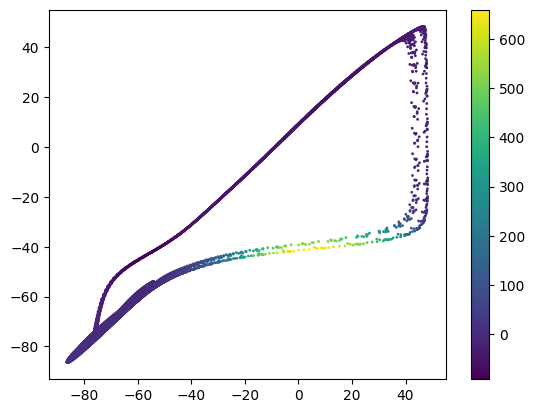

In [15]:
x = training_neuron.sol[time_delay:, 0]
y = training_neuron.sol[:-time_delay, 0]
dx = x[1:] - x[:-1]
dx[-1] = 0
i = stimulus.stimulus_list[time_delay:]
avg_i = (i[:-1]+i[1:])/2
dx = dx/time_range[2] - avg_i
plt.scatter(x[:-1], y[:-1], c=dx[:], s=1)
plt.colorbar()

In [33]:
"""prediction based on test neuron and stimulus"""

stimulus_test = lib.lorenz1963_stimulus(time_range=time_range, )
stimulus_test.get_stimulus_list()
test_neuron = lib.single_neuron_odeint(stimulus_test, [-10, 0, 0.8, 0.5])
test_neuron.generate_sol()

initial_piece_len = time_delay*(time_delay_dim-1) + 1
prediction_start_after = 1200
initial_piece = test_neuron.sol[prediction_start_after:prediction_start_after+initial_piece_len, 0]
stimulus_list = stimulus_test.stimulus_list[prediction_start_after+initial_piece_len:]
pred_run = lib.generate_prediction_with_current(pred_model, time_delay, time_delay_dim, stimulus_list, initial_piece)
pred_run.run(params, n_steps=20000)

100%|██████████| 20000/20000 [06:33<00:00, 50.81it/s]


In [16]:
"""prediction based on training neuron and stimulus"""
initial_piece_len = time_delay*(time_delay_dim-1) + 1
prediction_start_after = 1200
initial_piece = training_neuron.sol[prediction_start_after:prediction_start_after+initial_piece_len, 0]
stimulus_list = stimulus.stimulus_list[prediction_start_after+initial_piece_len:]
pred_run = lib.generate_prediction_with_current(pred_model, time_delay, time_delay_dim, stimulus_list, initial_piece)
pred_run.run(params, n_steps=20000)

100%|██████████| 20000/20000 [06:28<00:00, 51.46it/s]


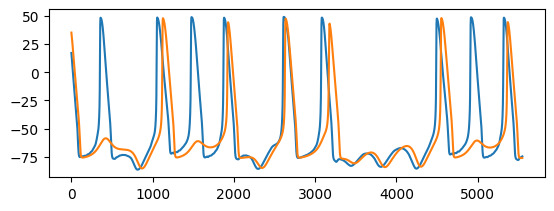

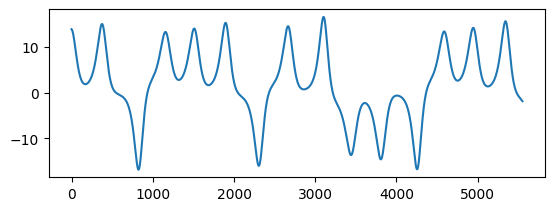

In [38]:
start = initial_piece_len + -initial_piece_len +2000
end = initial_piece_len + 7500

plt.figure(1)
plt.subplot(211)
plt.plot(pred_run.prediction_list[start:end])
plt.plot(training_neuron.sol[prediction_start_after+start: prediction_start_after+end, 0])
plt.figure(2)
plt.subplot(212)
plt.plot(training_neuron.stimulus.stimulus_list[prediction_start_after+start: prediction_start_after+end])
# plt.plot(test_neuron.sol[start+prediction_start_after:end+prediction_start_after, 0])

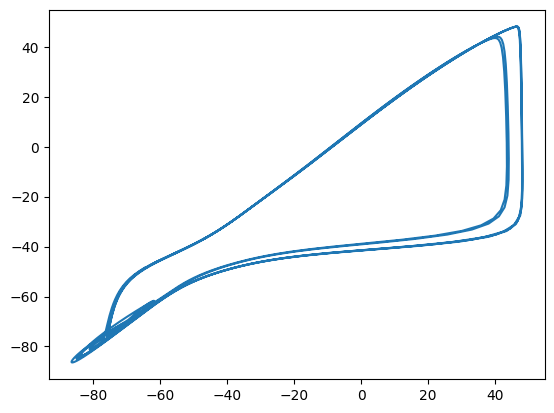

In [23]:
# plt.plot(pred_run.prediction_list[start+time_delay:end], pred_run.prediction_list[start:end-time_delay])
plt.plot(training_neuron.sol[prediction_start_after+start+time_delay: prediction_start_after+end, 0], training_neuron.sol[prediction_start_after+start: prediction_start_after+end-time_delay, 0])
# plt.scatter(kmeans.cluster_centers_[:, -1], kmeans.cluster_centers_[:, -2], s=1, c="red")